In [2]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import cvxpy as cp
import json
import time
from agents.rbc import RBC
from copy import deepcopy
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns

In [4]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)
env1 = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [5]:
### load weather data for calculation of COP
with open(env.data_path / env.weather_file) as csv_file:
    weather_data = pd.read_csv(csv_file)
weather_data = weather_data['Outdoor Drybulb Temperature [C]']

## Load Data

In [6]:
def parse_data(data:dict, current_data:dict):
    """ Parses `current_data` for optimization and loads into `data` """
    assert len(current_data) == 27, "Invalid number of parameters. Can't run basic (root) agent optimization"
    
    for key, value in current_data.items():
        if key not in data:
            data[key] = []
        data[key].append(value)
        
    for key, value in current_data.items():
        if np.array(data[key]).shape == (1, 9):#removes duplicates
            data[key] = [value]
    return data

In [7]:
def get_dimensions(data:dict):
    """ Gets shape of each param """
    for key in data.keys():
        print(data[key].shape)

In [8]:
def get_building(data:dict, building_id:int):
    """ Loads data (dict) from a particular building. 1-based indexing for building """
    assert building_id > 0, "building_id is 1-based indexing."
    building_data = {}
    for key in data.keys():
        building_data[key] = np.array(data[key])[:, building_id - 1]
    return building_data

## Optimization

In [9]:
def convert_to_numpy(params:dict):
    """ Converts dic[key] to nd.array """
    for key in params:
        if key == 'c_bat_end' or key == 'c_Csto_end' or key == 'c_Hsto_end':
            params[key] = np.array([params[key][-1], params[key][-1]])
            params[key][1] = 0.1
        else:
            params[key] = np.array(params[key])

In [10]:
def create_random_data(data:dict):
    """ Creates random data drawn from Gaussian. """
    for key in data:
        data[key] = np.clip(np.random.random(size=data[key].shape), 0, 1)
    return data

In [11]:
def get_actions(data:dict, t, debug=False, apply_seed=False, lookahead=False):
    """ Runs Optim for all 9 buildings per hour. `lookahead` once set to `True` computes day-ahead dispatch """
    convert_to_numpy(data)
    data = create_random_data(deepcopy(data)) if apply_seed else data
    if debug:
        return [Optim(t, data, i, actions_spaces[i].shape[0]) for i in range(9)]

    return [Optim(t, data, i, actions_spaces[i].shape[0]).solve(debug, lookahead) for i in range(1)]

## RBC for Data Collection 

In [12]:
def get_idx_hour():
    # Finding which state 
    with open('buildings_state_action_space.json') as file:
        actions_ = json.load(file)

    indx_hour = -1
    for obs_name, selected in list(actions_.values())[0]['states'].items():
        indx_hour += 1
        if obs_name=='hour':
            break
        assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
    return indx_hour

In [13]:
def estimate_data(surrogate_env:CityLearn, data:dict, t_start:int, init_updates:dict):
    """ Returns data for hours `t_start` - 24 using `surrogate_env` running RBC `agent` """
    for i in range(0, 24):
        data = parse_data(data, get_current_data(surrogate_env, t_start + i))
        
    return init_values(data, init_updates)[0] if t_start == 0 else data #only load previous values at start of day

In [14]:
def get_rbc_data(surrogate_env:CityLearn, state, indx_hour:int, dump_data:list, run_timesteps:int):
    """ Runs RBC for x number of timesteps """
    ## --- RBC generation ---
    for i in range(run_timesteps):
        hour_state = np.array([[state[0][indx_hour]]])
        action = agents.select_action(hour_state) #using RBC to select next action given current sate
        next_state, rewards, done, _ = surrogate_env.step(action)
        state = next_state
        dump_data.append([x[26] for x in state])

In [15]:
def init_values(data:dict, update_values:dict=None):
    """ Loads eod values for SOC and E_grid_past before(after) wiping data cache """
    if update_values:
        #assign previous day's end socs.
        data['c_bat_end'][0] =  update_values['c_bat_end']
        data['c_Hsto_end'][0] = update_values['c_Hsto_end']
        data['c_Csto_end'][0] = update_values['c_Csto_end']
            
        #assign previous day's end E_grid.
        data['E_grid_past'][0] = update_values['E_grid_past']
    else:
        update_values = {'c_bat_end' : data['c_bat_end'][-1], 'c_Hsto_end' : data['c_Hsto_end'][-1], 
                         'c_Csto_end' : data['c_Csto_end'][-1], 'E_grid_past' : data['E_grid_past'][-1]}
        
    return data, update_values

In [16]:
def get_ramping_rbc(day_data):
    arr = []
    for day in range(len(day_data) // 24): #number of days
        data = day_data[day : day + 24]
        arr.append( np.sum(np.abs(data[1:] - data[:-1])) )
    return arr

In [17]:
def get_peak_rbc(day_data):
    arr = []
    for day in range(len(day_data) // 24): #number of days
        arr.append(np.max(day_data[day : day + 24]))
    return arr

In [18]:
def get_virtual_electricity_rbc(day_data):
    arr = []
    p_ele = np.array([2 if 10 <= i <= 20 else 0.2 for i in range(24)])
    for day in range(len(day_data) // 24): #number of days
        arr.append(np.sum(p_ele * day_data[day : day + 24]))
    return arr

In [19]:
def get_current_data(env, t):
    """ Returns data:dic for each building from `env` for `t` timestep """
    ### FB - Full batch. Trim output X[:time-step]
    ### CT - current timestep only. X = full_data[time-step], no access to full_data
    ### DP - dynamic update. time-step k = [... k], time-step k+n = [... k + n].
    ### P - constant value across all time steps. changes per building only.
    
    _max_load = 2 * 168 # 2-week max load
    _num_buildings = len(actions_spaces) # total number of buildings in env.
    _start = max(t - _max_load, 0)
    observation_data = {}
    
    p_ele = [2 if 10 <= t % 24 <= 20 else 0.2 for i in range(1, _num_buildings+1)] # FB -- virtual electricity price.
    #can't get future data since action dependent -- > eod hour. (1, 9)
    E_grid_past = [0] #FB -- replace w/ per building cost
    ramping_cost_coeff = [0.1 for i in range(_num_buildings)] #P  -- initialized to 0.1, learned through diff.
    
    # Loads
    E_ns = [env.buildings['Building_'+str(i)].sim_results['non_shiftable_load'][t] for i in range(1, _num_buildings+1)] #CT
    H_bd = [env.buildings['Building_'+str(i)].sim_results['dhw_demand'][t] for i in range(1, _num_buildings+1)] #DP
    C_bd = [env.buildings['Building_'+str(i)].sim_results['cooling_demand'][t] for i in range(1, _num_buildings+1)] #DP
    H_max = 1.2 * np.max([env.buildings['Building_'+str(i)].sim_results['dhw_demand'][_start : t+24] for i in range(1, _num_buildings+1)], axis=1) #DP
    C_max = 1.2 * np.max([env.buildings['Building_'+str(i)].sim_results['cooling_demand'][_start : t+24] for i in range(1, _num_buildings+1)], axis=1) #DP

    # PV generations
    E_pv = [env.buildings['Building_'+str(i)].sim_results['solar_gen'][t] for i in range(1, _num_buildings+1)] #CT
    
    # Heat Pump
    eta_hp = [0.22]*_num_buildings #P
    t_C_hp = [8]*_num_buildings #P target cooling temperature (universal constant)
    
    #### CityLearn.py def. doesn't make too much sense. !!!! NOTE: THIS IS NOT UDPATED to CITYLEARN !!!!
    COP_C = [eta_hp[i] * float(t_C_hp[i] + 273.15) / float(273.15 + weather_data[t] - t_C_hp[i])  for i in range(_num_buildings)] #DP
    
    E_hpC_max = [None]*_num_buildings
    for i in range(1, _num_buildings + 1):
        try:
            E_hpC_max[i - 1] = np.max(env.buildings['Building_'+str(i)].sim_results['non_shiftable_load'][:t+24]) / COP_C[i - 1]
            max_soc = np.max(env.buildings['Building_'+str(i)].cooling_storage.soc[:t+24])
            E_hpC_max[i - 1] = max(E_hpC_max[i - 1], max_soc)

        except ValueError:
            pass

    
    # Electric Heater
    eta_ehH = [0.9]*_num_buildings #P
    #replaced capacity (not avaiable in electric heater) w/ nominal_power
    E_ehH_max = [H_max[i] / eta_ehH[i] for i in range(_num_buildings)] #P
    
    # Battery
    C_f_bat = [0.00001 for i in range(_num_buildings)] #P
    C_p_bat = [100]*_num_buildings #P (range: [20, 200])
    eta_bat = [1]*_num_buildings #P
    #current hour soc. normalized
    c_bat_end = [None]*_num_buildings #can't get future data since action dependent
    for i in range(1, _num_buildings+1):
        building = env.buildings['Building_' + str(i)].electrical_storage
        c_bat_end[i-1] = building.soc[t] / building.capacity
    
    # Heat (Energy->dhw) Storage
    C_f_Hsto = [0.008]*_num_buildings #P
    C_p_Hsto = 2 * C_max #P
    eta_Hsto = [1]*_num_buildings #P
    #current hour soc. normalized
    c_Hsto_end = [None]*_num_buildings #can't get future data since action dependent
    for i in range(1, _num_buildings+1):
        building = env.buildings['Building_' + str(i)].dhw_storage
        c_Hsto_end[i-1] = building.soc[t] / building.capacity 
        
    # Cooling (Energy->cooling) Storage
    C_f_Csto = [0.006]*_num_buildings #P
    C_p_Csto = [2]*_num_buildings #P
    eta_Csto = [1]*_num_buildings #P
    #current hour soc. normalized
    c_Csto_end = [None]*_num_buildings #can't get future data since action dependent
    for i in range(1, _num_buildings+1):
        building = env.buildings['Building_' + str(i)].cooling_storage
        c_Csto_end[i-1] = building.soc[t] / building.capacity
    
    
    # fill data
    observation_data['p_ele'] = p_ele
    observation_data['ramping_cost_coeff'] = ramping_cost_coeff
    observation_data['E_grid_past'] = E_grid_past
    
    observation_data['E_ns'] = E_ns
    observation_data['H_bd'] = H_bd
    observation_data['C_bd'] = C_bd
    observation_data['H_max'] = H_max
    observation_data['C_max'] = C_max
    
    observation_data['E_pv'] = E_pv
    
    observation_data['E_hpC_max'] = E_hpC_max
    observation_data['eta_hp'] = eta_hp
    observation_data['t_C_hp'] = t_C_hp
    observation_data['COP_C'] = COP_C
    
    observation_data['eta_ehH'] = eta_ehH
    observation_data['E_ehH_max'] = E_ehH_max
    
    observation_data['C_f_bat'] = C_f_bat
    observation_data['C_p_bat'] = C_p_bat
    observation_data['eta_bat'] = eta_bat
    observation_data['c_bat_end'] = c_bat_end
    
    observation_data['C_f_Hsto'] = C_f_Hsto
    observation_data['C_p_Hsto'] = C_p_Hsto
    observation_data['eta_Hsto'] = eta_Hsto
    observation_data['c_Hsto_end'] = c_Hsto_end
    
    observation_data['C_f_Csto'] = C_f_Csto
    observation_data['C_p_Csto'] = C_p_Csto
    observation_data['eta_Csto'] = eta_Csto
    observation_data['c_Csto_end'] = c_Csto_end
    
    return observation_data

In [20]:
class Optim:
    """ Define Differential Optimization framework for CL. """
    def __init__(self, t:int, parameters:dict, building_id:int, num_actions:int):
        """ 
        @Param:
        - `parameters` : data (dict) from r <= t <= T following `get_current_data` format.
        - `T` : 24 hours (constant)
        - `t` : hour to solve optimization for.
        - `building_id`: building index number (0-based)
        - `num_actions`: Number of actions for building 
            NOTE: right now, this is an integer, but will be checked programmatically.
        Solves per building as specified by `building_id`. Note: 0 based.
        """
        T = 24
        window = T - t
        self.constraints = []
        self.costs = []
        self.t = t
        self.num_actions = num_actions
        
        # -- define action space -- #
        bounds_high, bounds_low = np.vstack([actions_spaces[building_id].high, actions_spaces[building_id].low])
        #parse to dictionary --- temp... need to check w/ state-action-dictionary.json !!! @Zhaiyao !!!
        if len(bounds_high) == 2:
            bounds_high = {'action_H' : bounds_high[0], 'action_C' : None, 'action_bat' : bounds_high[1]}
            bounds_low = {'action_H' : bounds_low[0], 'action_C' : None, 'action_bat' : bounds_low[1]}
        else:
            bounds_high = {'action_H' : bounds_high[0], 'action_C' : bounds_high[1], 'action_bat' : bounds_high[2]}
            bounds_low = {'action_H' : bounds_low[0], 'action_C' : bounds_low[1], 'action_bat' : bounds_low[2]}
            
        # -- define action space -- #
        
        #define parameters and variables
        
        
        ### --- Parameters ---
        p_ele = cp.Parameter(name='p_ele', shape=(window), value=parameters['p_ele'][t:, building_id])
        E_grid_prevhour = cp.Parameter(name='E_grid_prevhour', 
                                       value=parameters['E_grid_past'][min(t-1, 0), building_id])
        
        #### 0 for day-ahead.
#         E_grid_pkhist = cp.Parameter(name='E_grid_pkhist', 
#                                     value=parameters['E_grid_past'][:(t+1), building_id].max())
        E_grid_pkhist = cp.Parameter(name='E_grid_pkhist', value=0)

        # max-min normalization of ramping_cost to downplay E_grid_sell weight.
        ramping_cost_coeff = cp.Parameter(name='ramping_cost_coeff', 
                                          value=parameters['ramping_cost_coeff'][t, building_id])
        
        # Loads
        E_ns = cp.Parameter(name='E_ns', shape=(window), value=parameters['E_ns'][t:, building_id])
 
        H_bd = cp.Parameter(name='H_bd', shape=(window), value=parameters['H_bd'][t:, building_id])
        C_bd = cp.Parameter(name='C_bd', shape=(window), value=parameters['C_bd'][t:, building_id])
        
        # PV generations
        E_pv = cp.Parameter(name='E_pv', shape=(window), value=parameters['E_pv'][t:, building_id])

        # Heat Pump
        COP_C = cp.Parameter(name='COP_C', shape=(window), value=parameters['COP_C'][t:, building_id])
        E_hpC_max = cp.Parameter(name='E_hpC_max', value=parameters['E_hpC_max'][t, building_id])

        # Electric Heater
        eta_ehH = cp.Parameter(name='eta_ehH', value=parameters['eta_ehH'][t, building_id])
        E_ehH_max = cp.Parameter(name='E_ehH_max', value=parameters['E_ehH_max'][t, building_id])

        # Battery
        C_f_bat = cp.Parameter(name='C_f_bat', value=parameters['C_f_bat'][t, building_id])
        C_p_bat = parameters['C_p_bat'][t, building_id] #cp.Parameter(name='C_p_bat', value=parameters['C_p_bat'][t, building_id])
        eta_bat = cp.Parameter(name='eta_bat', value=parameters['eta_bat'][t, building_id])
        soc_bat_init = cp.Parameter(name='soc_bat_init', value=parameters['c_bat_end'][0, building_id])
        #soc_bat_norm_end = cp.Parameter(name='soc_bat_norm_end', value=parameters['c_bat_end'][1, building_id])
        
        # Heat (Energy->dhw) Storage
        C_f_Hsto = cp.Parameter(name='C_f_Hsto', value=parameters['C_f_Hsto'][t, building_id]) #make constant.
        C_p_Hsto = cp.Parameter(name='C_p_Hsto', value=parameters['C_p_Hsto'][t, building_id])
        eta_Hsto = cp.Parameter(name='eta_Hsto', value=parameters['eta_Hsto'][t, building_id])
        soc_Hsto_init = cp.Parameter(name='soc_Hsto_init', value=parameters['c_Hsto_end'][0, building_id])
        
        #print('param',parameters['c_bat_end'][0, building_id],parameters['c_Hsto_end'][0, building_id])

        # Cooling (Energy->cooling) Storage
        C_f_Csto = cp.Parameter(name='C_f_Csto', value=parameters['C_f_Csto'][t, building_id])
        C_p_Csto = cp.Parameter(name='C_p_Csto', value=parameters['C_p_Csto'][t, building_id])
        eta_Csto = cp.Parameter(name='eta_Csto', value=parameters['eta_Csto'][t, building_id])
        soc_Csto_init = cp.Parameter(name='soc_Csto_init', value=parameters['c_Csto_end'][0, building_id])

        ### --- Variables ---
        
        #relaxation variables - prevents numerical failures when solving optimization
        E_bal_relax = cp.Variable(name='E_bal_relax', shape=(window)) #electricity balance relaxation
        H_bal_relax = cp.Variable(name='H_bal_relax', shape=(window)) #heating balance relaxation
        C_bal_relax = cp.Variable(name='C_bal_relax', shape=(window)) #cooling balance relaxation
        
        E_grid = cp.Variable(name='E_grid', shape=(window)) #net electricity grid
        E_grid_sell = cp.Variable(name='E_grid_sell', shape=(window)) #net electricity grid
        
        E_hpC = cp.Variable(name='E_hpC', shape=(window)) #heat pump
        E_ehH = cp.Variable(name='E_ehH', shape=(window)) #electric heater
        
        SOC_bat = cp.Variable(name='SOC_bat', shape=(window)) #electric battery
        SOC_Brelax = cp.Variable(name='SOH_Brelax', shape=(window)) #electrical battery relaxation (prevents numerical infeasibilities)
        action_bat = cp.Variable(name='action_bat', shape=(window)) #electric battery
    
        SOC_H = cp.Variable(name='SOC_H', shape=(window)) #heat storage
        SOC_Hrelax = cp.Variable(name='SOH_Crelax', shape=(window)) #heat storage relaxation (prevents numerical infeasibilities)
        action_H = cp.Variable(name='action_H', shape=(window)) #heat storage

        SOC_C = cp.Variable(name='SOC_C', shape=(window)) #cooling storage
        SOC_Crelax = cp.Variable(name='SOC_Crelax', shape=(window)) #cooling storage relaxation (prevents numerical infeasibilities)
        action_C = cp.Variable(name='action_C', shape=(window)) #cooling storage
        
        
        ### objective function
        ramping_cost = cp.abs(E_grid[0] - E_grid_prevhour) + cp.sum(cp.abs(E_grid[1:] - E_grid[:-1])) # E_grid_t+1 - E_grid_t
        peak_net_electricity_cost = cp.max(cp.atoms.affine.hstack.hstack([*E_grid, E_grid_pkhist])) #max(E_grid, E_gridpkhist)
        electricity_cost = cp.sum(p_ele * E_grid)
        selling_cost = -1e2 * cp.sum(E_grid_sell) #not as severe as violating constraints
        
        ### relaxation costs - L1 norm
        # balance eq.
        E_bal_relax_cost = cp.sum(cp.abs( E_bal_relax ))
        H_bal_relax_cost = cp.sum(cp.abs( H_bal_relax ))
        C_bal_relax_cost = cp.sum(cp.abs( C_bal_relax ))
        # soc eq.
        SOC_Brelax_cost = cp.sum(cp.abs( SOC_Brelax ))
        SOC_Crelax_cost = cp.sum(cp.abs( SOC_Crelax ))
        SOC_Hrelax_cost = cp.sum(cp.abs( SOC_Hrelax ))
        
        self.costs.append(electricity_cost + selling_cost+E_bal_relax_cost*1e4 + H_bal_relax_cost*1e4 + C_bal_relax_cost*1e4 
                          + SOC_Brelax_cost*1e4 + SOC_Crelax_cost*1e4 + SOC_Hrelax_cost*1e4)
        
        
        ### constraints
        self.constraints.append( E_grid >= 0 )
        self.constraints.append( E_grid_sell <= 0 )
        
        #energy balance constraints
        self.constraints.append( E_pv + E_grid + E_grid_sell + E_bal_relax == E_ns + E_hpC + E_ehH + action_bat * C_p_bat) #electricity balance
        self.constraints.append( E_ehH * eta_ehH + H_bal_relax == action_H * C_p_Hsto + H_bd ) #heat balance
        
        #!!!!! Problem Child !!!!!
        self.constraints.append( E_hpC * COP_C + C_bal_relax == action_C * C_p_Csto + C_bd ) #cooling balance
        #!!!!! Problem Child !!!!!
        
        
        #heat pump constraints
        self.constraints.append( E_hpC <= E_hpC_max ) #maximum cooling
        self.constraints.append( E_hpC >= 0 ) #constraint minimum cooling to positive
        #electric heater constraints
        self.constraints.append( E_ehH >= 0 ) #constraint to PD
        self.constraints.append( E_ehH <= E_ehH_max ) #maximum limit
        
        #electric battery constraints
        
        self.constraints.append( SOC_bat[0] == (1 - C_f_bat)*soc_bat_init + action_bat[0]*eta_bat + SOC_Crelax[0] ) #initial SOC
        #soc updates
        for i in range(1, window): #1 = t + 1
            self.constraints.append( SOC_bat[i] == (1 - C_f_bat)*SOC_bat[i - 1] + action_bat[i]*eta_bat + SOC_Crelax[i])
        self.constraints.append(SOC_bat >= 0) #battery SOC bounds
        self.constraints.append(SOC_bat <= 1) #battery SOC bounds

        #Heat Storage constraints
        self.constraints.append( SOC_H[0] == (1 - C_f_Hsto) * soc_Hsto_init + action_H[0]*eta_Hsto + SOC_Hrelax[0]) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_H[i] == (1 - C_f_Hsto)*SOC_H[i - 1] + action_H[i]*eta_Hsto + SOC_Hrelax[i])
        self.constraints.append(SOC_H >= 0) #battery SOC bounds
        self.constraints.append(SOC_H <= 1) #battery SOC bounds
        
        #Cooling Storage constraints
        self.constraints.append( SOC_C[0] == (1 - C_f_Csto) * soc_Csto_init + action_C[0]*eta_Csto + SOC_Crelax[0]) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_C[i] == (1 - C_f_Csto)*SOC_C[i - 1] + action_C[i]*eta_Csto + SOC_Crelax[i])
        self.constraints.append(SOC_C >= 0) #battery SOC bounds
        self.constraints.append(SOC_C <= 1) #battery SOC bounds
        
        
        #### action constraints (limit to action-space)
        #format: AS[building_id][0/1 (high/low)][heat, cool, battery]
        
        heat_high, cool_high, battery_high = bounds_high
        heat_low, cool_low, battery_low = bounds_low
        
        assert len(bounds_high) == 3, 'Invalid number of bounds for actions - see dict defined in `Optim`'
        
        for high, low in zip(bounds_high.items(), bounds_low.items()):
            key, h, l = [*high, low[1]]
            if not (h and l): #throw DeMorgan's in!!!
                continue
                
            #heating action
            if key == 'action_H':
                self.constraints.append(action_H <= h)
                self.constraints.append(action_H >= l)
            #cooling action
            elif key == 'action_C':
                self.constraints.append(action_C <= h)
                self.constraints.append(action_C >= l)
            #Battery action
            elif key == 'action_bat':
                self.constraints.append(action_bat <= h)
                self.constraints.append(action_bat >= l)

    def get_problem(self):
        """ Returns raw problem """
        # Form objective.
        obj = cp.Minimize(*self.costs)
        # Form and solve problem.
        prob = cp.Problem(obj, self.constraints)
        
        return prob
    
    def get_constraints(self):
        """ Returns constraints for problem """
        return self.constraints
    
    def solve(self, debug=False, dispatch=False):
        prob = self.get_problem() #Form and solve problem
        status = prob.solve(verbose=debug)  # Returns the optimal value.
        #print(prob.status)

        if float('-inf') < status < float('inf'):
            pass
        else:
            return "Unbounded Solution"
            
        actions = {}
        for var in prob.variables():
            if dispatch:
                actions[var.name()] = np.array(var.value) #no need to clip... automatically restricts range
            else:
                actions[var.name()] = var.value[0] #no need to clip... automatically restricts range
        
        #Temporary... needs fixing!
        ## compute dispatch cost
        params = {x.name() : x.value for x in prob.parameters()}

        if dispatch:
            ramping_cost = np.sum(np.abs(actions['E_grid'][1: ] + actions['E_grid_sell'][1: ] - 
                                         actions['E_grid'][:-1] - actions['E_grid_sell'][:-1]))
            net_peak_electricity_cost = np.max(actions['E_grid'])
            virtual_electricity_cost = np.sum(params['p_ele'] * actions['E_grid'])
            dispatch_cost = virtual_electricity_cost #ramping_cost + net_peak_electricity_cost + virtual_electricity_cost
            
        if self.num_actions == 2:
            return [actions['action_H'], actions['action_bat']], dispatch_cost if dispatch else None
        return [actions['action_C'], actions['action_H'], actions['action_bat']], dispatch_cost if dispatch else None

# r = 1

In [52]:
state = env.reset()
sac_actions_list = []
actions_arr = []
t_idx = 0 
data = {}
data_est_ = []
observations_spaces, actions_spaces = env.get_state_action_spaces()
state1 = env1.reset()
observations_spaces1, actions_spaces = env.get_state_action_spaces()
indx_hour = get_idx_hour()
model = RBC(actions_spaces)
for i in tqdm(range(24*30)):
    hour_state = np.array([[state[0][indx_hour]]])
    action = model.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    
    if t_idx == 24:
        #print(t_idx)
        init_updates = {'c_bat_end': [0], 'c_Hsto_end': [0], 'c_Csto_end': [0], 'E_grid_past': [0]}
    if t_idx>=24:
        #print(t_idx)
        data = {}
        data_est = estimate_data(env, deepcopy(data), t_idx-24, init_updates)
        #print('data_est  1 ',data_est ['c_bat_end'],data_est ['c_Hsto_end'])
        data_est['c_bat_end'] = [init_updates['c_bat_end']]
        data_est['c_Hsto_end'] = [init_updates['c_Hsto_end']]
        data_est['c_Csto_end'] = [init_updates['c_Csto_end']]
        #print('data_est   2 ',data_est['c_bat_end'],data_est['c_Hsto_end'])
        optim_results = get_actions(data_est, 0, lookahead=True) 
        action_planned_day, cost_dispatch = zip(*optim_results)
        actions = [np.array(action_planned_day[idx])[:, 0] for idx in range(len(actions_spaces))]
        actions_arr.append(actions)
        next_state, rewards, done, _ = env1.step(actions)
        init_updates = {'c_bat_end': [env1.buildings['Building_1'].electrical_storage.soc[t_idx-24]/ env1.buildings['Building_1'].electrical_storage.capacity], 
                        'c_Hsto_end': [env1.buildings['Building_1'].dhw_storage.soc[t_idx-24]/ env1.buildings['Building_1'].dhw_storage.capacity], 
                        'c_Csto_end': [env1.buildings['Building_1'].cooling_storage.soc[t_idx-24]/ env1.buildings['Building_1'].cooling_storage.capacity], 
                        'E_grid_past': [0]}
        #print('init_updates',init_updates['c_bat_end'],init_updates['c_Hsto_end'])
    t_idx += 1
        

100%|██████████| 720/720 [01:16<00:00,  9.45it/s]


In [53]:
bd_actions = []
for actions in np.array(actions_arr):
    bd_actions.append(actions)
print(len(bd_actions))
state = env.reset()
sac_actions_list = []
observations_spaces, actions_spaces = env.get_state_action_spaces()
for i in range(0,int(len( bd_actions))):
    hour_state = np.array([[state[0][indx_hour]]])
    action = bd_actions[i]
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    sac_actions_list.append(actions)

696


In [54]:
building_number = 'Building_1'
d = env.buildings[building_number].__dict__#'time_step
list_param1 = ['electric_consumption_cooling', 
       'electric_consumption_cooling_storage', 'electric_consumption_dhw', 
       'electric_consumption_dhw_storage','cooling_device_to_building',
       'cooling_storage_to_building', 'cooling_device_to_storage', 'cooling_storage_soc', 
       'dhw_heating_device_to_building', 'dhw_storage_to_building', 'dhw_heating_device_to_storage', 
       'dhw_storage_soc', 'electrical_storage_electric_consumption', 'electrical_storage_soc']
d1= {}
d1['net_electric_consumption'] = env.net_electric_consumption
for i in list_param1:
    d1[i] = d[i]
df1 = pd.DataFrame.from_dict(d1)
df = pd.DataFrame.from_dict(d['sim_results'])
df1.to_csv('milp/results_r_1.csv') 
df.to_csv('milp/sim_results_r_1.csv') 

In [21]:
from agents.rbc import RBC

In [22]:
state = env.reset()
sac_actions_list = []
observations_spaces, actions_spaces = env.get_state_action_spaces()
indx_hour = get_idx_hour()
model = RBC(actions_spaces)
for i in range(8760):
    hour_state = np.array([[state[0][indx_hour]]])
    action = model.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state

In [23]:
building_number = 'Building_1'
d = env.buildings[building_number].__dict__#'time_step
list_param1 = ['electric_consumption_cooling', 
       'electric_consumption_cooling_storage', 'electric_consumption_dhw', 
       'electric_consumption_dhw_storage','cooling_device_to_building',
       'cooling_storage_to_building', 'cooling_device_to_storage', 'cooling_storage_soc', 
       'dhw_heating_device_to_building', 'dhw_storage_to_building', 'dhw_heating_device_to_storage', 
       'dhw_storage_soc', 'electrical_storage_electric_consumption', 'electrical_storage_soc']
d1= {}
d1['net_electric_consumption'] = env.net_electric_consumption
for i in list_param1:
    d1[i] = d[i]
df1 = pd.DataFrame.from_dict(d1)
df = pd.DataFrame.from_dict(d['sim_results'])
df1.to_csv('milp/results_RBC.csv') 
df.to_csv('milp/sim_results_RBC.csv') 

In [24]:
500*12*0.157

942.0

In [25]:
679.34

679.34

In [26]:
sum(env.net_electric_consumption)/10

18607.76506729871

In [27]:
18607- 1000

17607

In [51]:
sum(env.net_electric_consumption)/10*0.2 + 500*12*0.157

4663.553013459743

In [59]:
x2 = sum(env.net_electric_consumption)/10*0.2+679.34*12*0.157
x2

5001.429573459743

In [72]:
x = 16607.76*0.2+550.34*12*0.157
x 

4358.39256

In [73]:
(x-x2)/x2

-0.12857064245631697

In [70]:
x = 17208.23*0.2+575.27*12*0.157
x 

4525.45468

In [71]:
(x-x2)/x2

-0.09516776882864049

In [64]:
3920.82/1895.67

2.0683030274256597

In [78]:
x = 16782.31*0.2+573.21*12*0.157
print(x, (x-x2)/x2)

4436.38964 -0.11297568528369291


In [82]:
x = 17256.26*0.2+583.67*12*0.157
print(x, (x-x2)/x2)

4550.88628 -0.09008290266658284


In [88]:
x = 17964.53*0.2+592.32*12*0.157
print(x, (x-x2)/x2)

4708.83688 -0.05850181216434516


In [92]:
x = 18446.32*0.2+652.32*12*0.157
print(x, (x-x2)/x2)

4918.23488 -0.016634182734716122


In [93]:
652.32*12

7827.84

# r = 0.9

In [45]:
l = 10*24
noise1 = np.random.normal(0, 3, l )
noise2 = np.random.normal(0, 0.5, l)
noise3 = np.random.normal(0, 10, l)
noise4 = np.random.normal(0, 0, l)

In [46]:
state = env.reset()
sac_actions_list = []
actions_arr = []
t_idx = 0 
data = {}
data_est_ = []
observations_spaces, actions_spaces = env.get_state_action_spaces()
state1 = env1.reset()
observations_spaces1, actions_spaces = env.get_state_action_spaces()
indx_hour = get_idx_hour()
model = RBC(actions_spaces)
for i in tqdm(range(24+l)):
    hour_state = np.array([[state[0][indx_hour]]])
    action = model.select_action(hour_state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    
    if t_idx == 24:
        #print(t_idx)
        init_updates = {'c_bat_end': [0], 'c_Hsto_end': [0], 'c_Csto_end': [0], 'E_grid_past': [0]}
    if t_idx>=24:
        #print(t_idx)
        data = {}
        data_est = estimate_data(env, deepcopy(data), t_idx-24, init_updates)
        #print('data_est  1 ',data_est ['c_bat_end'],data_est ['c_Hsto_end'])
        data_est['c_bat_end'] = [init_updates['c_bat_end']]
        data_est['c_Hsto_end'] = [init_updates['c_Hsto_end']]
        data_est['c_Csto_end'] = [init_updates['c_Csto_end']]
        k = 0
        for i in data_est['E_ns']:
            data_est['E_ns'][k] = [np.clip(i[0]+ noise1[k],0,1000000)]
            k+=1
        k = 0
        for i in data_est['H_bd']:
            data_est['H_bd'][k] = [np.clip(i[0]+ noise2[k],0,1000000)]
            k+=1
        k = 0
        for i in data_est['C_bd']:
            data_est['C_bd'][k] = [np.clip(i[0]+ noise3[k],0,1000000)]
            k+=1
        k = 0
        for i in data_est['E_pv']:
            data_est['E_pv'][k] = [np.clip(i[0]+ noise4[k],0,1000000)]
            k+=1
        
        #print('data_est   2 ',data_est['c_bat_end'],data_est['c_Hsto_end'])
        optim_results = get_actions(data_est, 0, lookahead=True) 
        action_planned_day, cost_dispatch = zip(*optim_results)
        actions = [np.array(action_planned_day[idx])[:, 0] for idx in range(len(actions_spaces))]
        actions_arr.append(actions)
        next_state, rewards, done, _ = env1.step(actions)
        init_updates = {'c_bat_end': [env1.buildings['Building_1'].electrical_storage.soc[t_idx-24]/ env1.buildings['Building_1'].electrical_storage.capacity], 
                        'c_Hsto_end': [env1.buildings['Building_1'].dhw_storage.soc[t_idx-24]/ env1.buildings['Building_1'].dhw_storage.capacity], 
                        'c_Csto_end': [env1.buildings['Building_1'].cooling_storage.soc[t_idx-24]/ env1.buildings['Building_1'].cooling_storage.capacity], 
                        'E_grid_past': [0]}
        #print('init_updates',init_updates['c_bat_end'],init_updates['c_Hsto_end'])
    t_idx += 1
        

100%|██████████| 264/264 [00:25<00:00, 10.15it/s]


In [47]:
bd_actions = []
for actions in np.array(actions_arr):
    bd_actions.append(actions)
print(len(bd_actions))
state = env.reset()
sac_actions_list = []
observations_spaces, actions_spaces = env.get_state_action_spaces()
for i in range(0,int(len( bd_actions))):
    hour_state = np.array([[state[0][indx_hour]]])
    action = bd_actions[i]
    next_state, rewards, done, _ = env.step(action)
    state = next_state
    sac_actions_list.append(actions)

240


In [51]:
sum(env.net_electric_consumption)

4535.801990181208

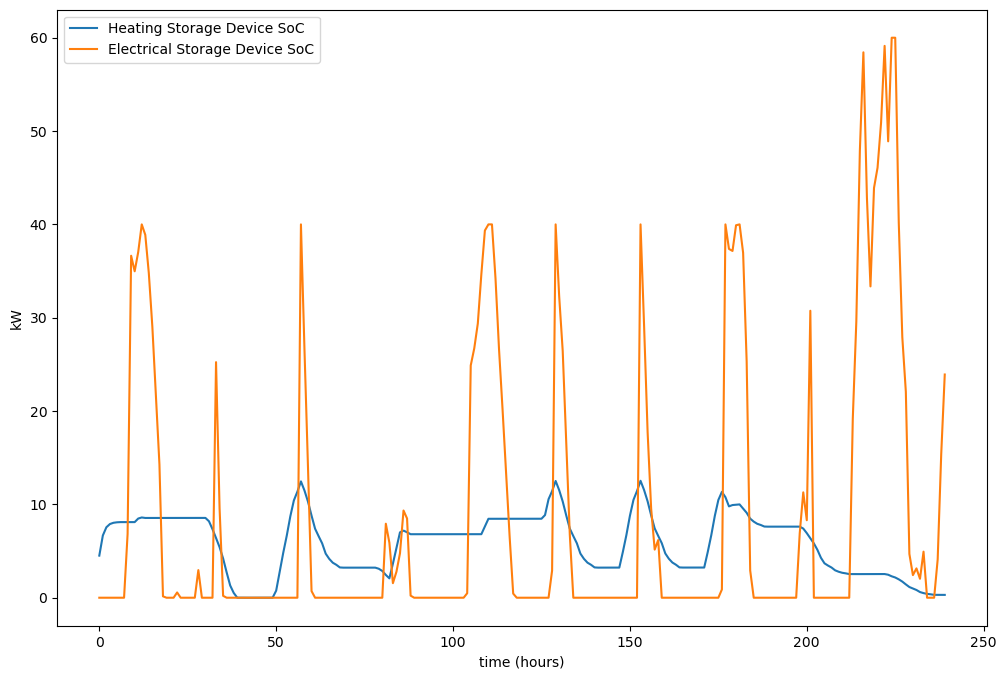

In [52]:
building_number = 'Building_1'
plt.figure(figsize=(12,8))
plt.plot(env.buildings[building_number].dhw_storage_soc)
plt.plot(env.buildings[building_number].electrical_storage_soc)
plt.xlabel('time (hours)')
plt.ylabel('kW')
plt.legend(['Heating Storage Device SoC', 
            'Electrical Storage Device SoC'])

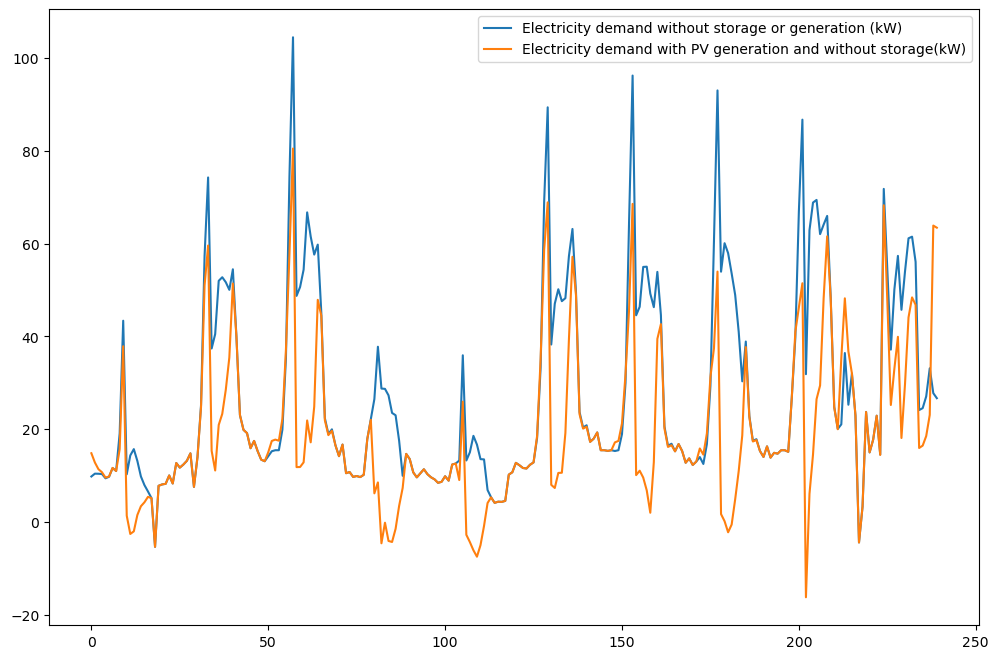

In [53]:
interval = []
plt.figure(figsize=(12,8))
a =  np.array(env.net_electric_consumption)
b = np.array(env.electric_generation)
c = np.array(env.electric_consumption_cooling_storage)
d = np.array(env.electric_consumption_dhw_storage)
plt.plot(a+b-c-d)
plt.plot(a)
plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)'])